In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm
from sklearn import kernel_approximation

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [3]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)

from useful_features import get_runs_report

runs_report_df = get_runs_report(df_meta)
runs_report_df.style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(runs_report_df.columns)[2:]
)

,pilote_id,file,Corr,corr_a,corr_b,f1_test,Neutral,Open,Pistol,Thumb,OK,Grab
0,1,2023-05-15_16-16-08,0.274356,0.412871,0.256877,0.777390,0.884373,0.877193,0.461059,0.000000,0.800566,0.787447
1,1,2023-05-15_17-12-24,0.020546,0.191707,0.023858,0.651936,0.804278,0.810093,0.275542,0.000000,0.393023,0.409266
2,1,2023-06-05_16-12-38,0.341675,0.448190,0.339225,0.598472,0.749415,0.757825,0.256061,0.000000,0.539741,0.390456
3,1,2023-06-05_17-53-01,0.353172,0.264307,0.413203,0.697992,0.815892,0.728455,0.587413,0.147420,0.624000,0.590832
4,1,2023-06-20_14-43-11,0.083280,0.179436,0.182742,0.624840,0.780345,0.681892,0.363977,0.000000,0.509735,0.482972
5,1,2023-06-20_13-30-15,0.274443,0.235754,0.382149,0.702782,0.808898,0.780488,0.323353,0.271264,0.706897,0.713101
6,1,2023-06-20_12-34-17,0.361622,0.414341,0.356253,0.733210,0.838020,0.807263,0.654867,0.000000,0.700152,0.768311
7,2,2023-09-30_08-06-44,0.400822,0.443222,0.358299,0.836533,0.893302,0.812903,0.759346,0.778667,0.727273,0.709059
8,2,2023-09-29_11-03-50,0.346494,0.384182,0.456843,0.903127,0.922294,0.909730,0.877232,0.923414,0.810875,0.860241
9,2,2023-09-29_09-20-47,0.271879,0.363008,0.308670,0.904558,0.924850,0.896391,0.874725,0.924779,0.903153,0.782835


In [4]:
first_pilot_data_idx = [3, 5]
second_pilot_data_idx = [8, 9, 15, 16]
third_pilot_data_idx = [18, 21]
fourth_pilot_data_idx = [22]

OMG_CH = [str(i) for i in range(50)]
ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

## Target shift function

In [5]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

## Data building

In [7]:
zeros = np.zeros((0, 65))

data = read_omg_csv(
            './data/' + runs_report_df.loc[0]['file'] + '.palm', 
            n_omg_channels=50,
            n_acc_channels=3, 
            n_gyr_channels=3, 
            n_enc_channels=6, 
            n_mag_channels=0
        )

pd.DataFrame(np.vstack((zeros, data.values)))

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,2.0,4.0,3.0,843.0,1831.0,1.0,1387.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,523008.0
1,5.0,5.0,4.0,840.0,1834.0,0.0,1391.0,3.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,523041.0
2,6.0,3.0,4.0,838.0,1830.0,3.0,1388.0,4.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,523074.0
3,0.0,2.0,3.0,832.0,1826.0,1.0,1383.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,523107.0
4,6.0,3.0,7.0,840.0,1834.0,2.0,1391.0,5.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,523140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,8.0,2.0,8.0,1791.0,2906.0,1.0,2819.0,12.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1484628.0
29141,5.0,1.0,7.0,1790.0,2904.0,1.0,2816.0,14.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1484661.0
29142,3.0,4.0,10.0,1794.0,2913.0,0.0,2824.0,17.0,6.0,6.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1484694.0
29143,4.0,9.0,9.0,1788.0,2909.0,1.0,2819.0,14.0,4.0,2.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1484727.0


In [8]:
protocol_features = [
    "Thumb","Index","Middle","Ring","Pinky",
    'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
]

In [18]:
def data_build(sets_idx_list):
    le = preprocessing.LabelEncoder()
    total_train_data, total_test_data = np.zeros((0, 65)), np.zeros((0, 65))
    total_train_target, total_test_target = np.zeros(0), np.zeros(0)
    
    for data_idx in sets_idx_list:
        palm_file = './data/' + df_meta.loc[data_idx]['montage']
        data = read_omg_csv(
            palm_file, 
            n_omg_channels=50,
            n_acc_channels=3, 
            n_gyr_channels=3, 
            n_enc_channels=6, 
            n_mag_channels=0
        )
        
        protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
        # FIT
        le.fit(
            protocol[protocol_features]
            .apply(lambda row: str(tuple(row)), axis=1)
        )
        # TRANSFORM
        protocol['gesture'] = le.transform(
            protocol[protocol_features]
            .apply(lambda row: str(tuple(row)), axis=1)
        )
        
        target = np.array([protocol['gesture'].loc[s] for s in data['SYNC'].values])

        target_shifted, _ = get_naive_centering(data.values, target, inter=1000, window=30, use_m=False)
        
        last_train_idx = df_meta[
            df_meta['montage'] == palm_file.split('/')[-1]
            ].to_dict(orient='records')[0]['last_train_idx']
        
        total_train_data = np.vstack((total_train_data, data[:last_train_idx].values))
        total_test_data = np.vstack((total_test_data, data[last_train_idx:].values))
        
        total_train_target = np.concatenate((total_train_target, target_shifted[:last_train_idx]))
        total_test_target = np.concatenate((total_test_target, target_shifted[last_train_idx:]))
    
    results_tuple = (total_train_data, total_test_data, total_train_target, total_test_target)
    
    return results_tuple
        

## Train-test split

In [19]:
first_pilot_train_pool, first_pilot_test_pool, first_pilot_train_target, first_pilot_test_target = data_build(first_pilot_data_idx)

print(first_pilot_train_pool.shape, first_pilot_train_target.shape)
print(first_pilot_test_pool.shape, first_pilot_test_target.shape)

(35699, 65) (35699,)
(8866, 65) (8866,)


In [20]:
second_pilot_train_pool, second_pilot_test_pool, second_pilot_train_target, second_pilot_test_target = data_build(second_pilot_data_idx)

print(second_pilot_train_pool.shape, second_pilot_train_target.shape)
print(second_pilot_test_pool.shape, second_pilot_test_target.shape)

(50275, 65) (50275,)
(20678, 65) (20678,)


In [21]:
third_pilot_train_pool, third_pilot_test_pool, third_pilot_train_target, third_pilot_test_target = data_build(third_pilot_data_idx)

print(third_pilot_train_pool.shape, third_pilot_train_target.shape)
print(third_pilot_test_pool.shape, third_pilot_test_target.shape)

(43038, 65) (43038,)
(11407, 65) (11407,)


In [22]:
fourth_pilot_train_pool, fourth_pilot_test_pool, fourth_pilot_train_target, fourth_pilot_test_target = data_build(fourth_pilot_data_idx)

print(fourth_pilot_train_pool.shape, fourth_pilot_train_target.shape)
print(fourth_pilot_test_pool.shape, fourth_pilot_test_target.shape)

(20756, 65) (20756,)
(5892, 65) (5892,)


---
---
---
---
---

## Select the pilot

In [110]:
# select pilot number
pilot_number = 1
# select n features
n_features = 50

train_pools = [
    first_pilot_train_pool, second_pilot_train_pool,
    third_pilot_train_pool, fourth_pilot_train_pool
]

test_pools = [
    first_pilot_test_pool, second_pilot_test_pool,
    third_pilot_test_pool, fourth_pilot_test_pool
]

train_targets = [
    first_pilot_train_target, second_pilot_train_target,
    third_pilot_train_target, fourth_pilot_train_target
]

test_targets = [
    first_pilot_test_target, second_pilot_test_target,
    third_pilot_test_target, fourth_pilot_test_target
]

X_train = train_pools[pilot_number-1][:, :n_features]
X_test = test_pools[pilot_number-1][:, :n_features]
y_train = train_targets[pilot_number-1]
y_test = test_targets[pilot_number-1]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(35699, 50) (35699,)
(8866, 50) (8866,)


# Preprocessing

In [111]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

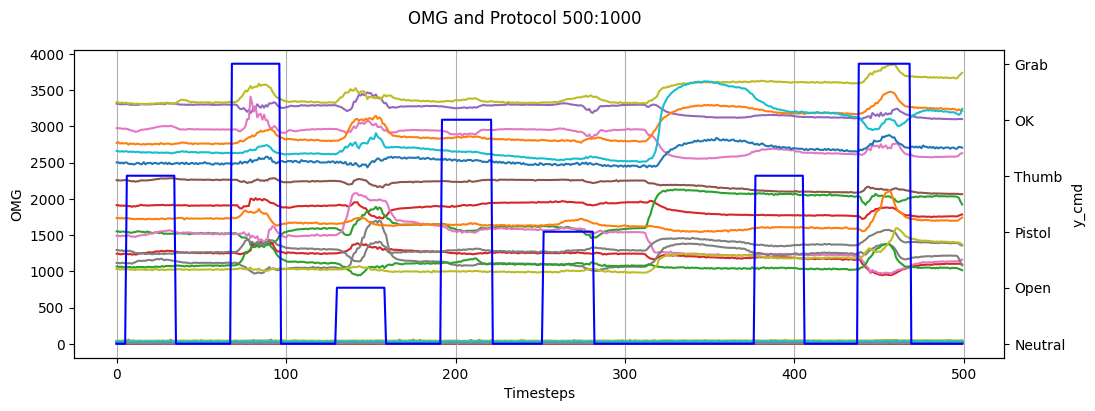

In [112]:
get_graphs(X_train, y_train, start=500, end=1000)

## Корреляционный анализ

In [113]:
def find_highly_correlated_features(data, threshold=0.9):
    """Функция корреляционного анализа

    Args:
        data (ndarray): Массив данных.
        threshold (float, optional): Порог корреляции. Defaults to 0.9.

    Returns:
        tuple:
            list: Спсиок пар номеров высоко скореллированных признаков.
            set: Множество оптимально-отобранных номеров признаков из
                высоко скореллированных пар.
    """
    # Строим корреляционную матрицу
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Находим индексы нижнего треугольника корреляционной матрицы
    lower_triangle_indices = np.tril_indices(corr_matrix.shape[0], k=-1)
    
    # Находим пары высоко скоррелированных признаков
    high_corr_features = [
        [i, j] for i, j in zip(
            lower_triangle_indices[0], lower_triangle_indices[1]
        ) if abs(corr_matrix[i, j]) > threshold
    ]

    hcf_copy = high_corr_features.copy()
    # Определяем features_to_remove
    features_to_remove = []
    while True:
        dct = {}
        for el in hcf_copy:
            for num in el:
                cnt = 0
                for l in hcf_copy:
                    if (num in l) and (len(l) == 2):
                        cnt += 1
                dct[num] = cnt
        
        if len(set(dct.values())) == 1:
            break
        
        if not dct:
            break

        num_tb_dltd = max(dct, key=dct.get)
        features_to_remove.append(num_tb_dltd)

        hcf_copy = [
            [x for x in inner_list if x != num_tb_dltd]
            for inner_list in hcf_copy
        ]

    return high_corr_features, list(set(features_to_remove))

In [114]:
high_corr_features, features_to_remove = find_highly_correlated_features(X_train, threshold=0.9)
print(high_corr_features)
print(features_to_remove)
len(features_to_remove)

[[22, 21], [30, 5], [31, 5], [31, 30], [38, 5], [38, 30], [38, 31]]
[5, 30]


2

Выберем и удалим высокоскореллированные признаки.

In [115]:
X_train_cd = np.delete(X_train, features_to_remove, axis=1)
X_test_cd = np.delete(X_test, features_to_remove, axis=1)

## Стандартизация

In [122]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train_cd)
X_test_scaled = std_scaler.transform(X_test_cd)

## Устранение мультиколлинеарности

In [123]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_scaled).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 48
Ранг матрицы:   48
Определитель:   1.3402541927312888e-17


In [124]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 48


In [125]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 48
Ранг матрицы:   48
Определитель:   0.9999999999999976


## Экспоненциальное сглаживаение

In [126]:
# Функция для экспоненциального сглаживания
def get_smoothing(Xdf, sample_size=5, alpha=0.3):
    """Функция для экспоненциального сглаживания

    Args:
        Xdf (ndarray): Массив данных.
        sample_size (int, optional): Размер сглаживаемой выборки. Defaults to 5.
        alpha (float, optional): Коэффициент сглаживания. Defaults to 0.3.

    Returns:
        ndarray: Преобразованный массив.
    """
    samples, j = [], 0
    for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
        x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)].ewm(alpha=alpha, adjust=True).mean().values
        samples.append(x_smoothed)
        j = i
    
    X_ewm = np.row_stack(samples)
    
    return X_ewm

In [127]:
X_train_ewm = get_smoothing(pd.DataFrame(X_train_pca), sample_size=10, alpha=0.3)
X_test_ewm = get_smoothing(pd.DataFrame(X_test_pca), sample_size=10, alpha=0.3)

print(X_train_pca.shape, y_train.shape)
print(X_test_pca.shape, y_test.shape)
print(X_train_ewm.shape, y_train.shape)
print(X_test_ewm.shape, y_test.shape)

(35699, 48) (35699,)
(8866, 48) (8866,)
(35690, 48) (35699,)
(8860, 48) (8866,)


In [128]:
diff1 = X_train_pca.shape[0] - X_train_ewm.shape[0]
diff2 = X_test_pca.shape[0] - X_test_ewm.shape[0]

zeros_array1 = np.zeros((diff1, X_train_pca.shape[1]))
zeros_array2 = np.zeros((diff2, X_test_pca.shape[1]))

X_train_ewm = np.vstack((X_train_ewm, zeros_array1))
X_test_ewm = np.vstack((X_test_ewm, zeros_array2))

print(X_train_ewm.shape, y_train.shape)
print(X_test_ewm.shape, y_test.shape)

(35699, 48) (35699,)
(8866, 48) (8866,)


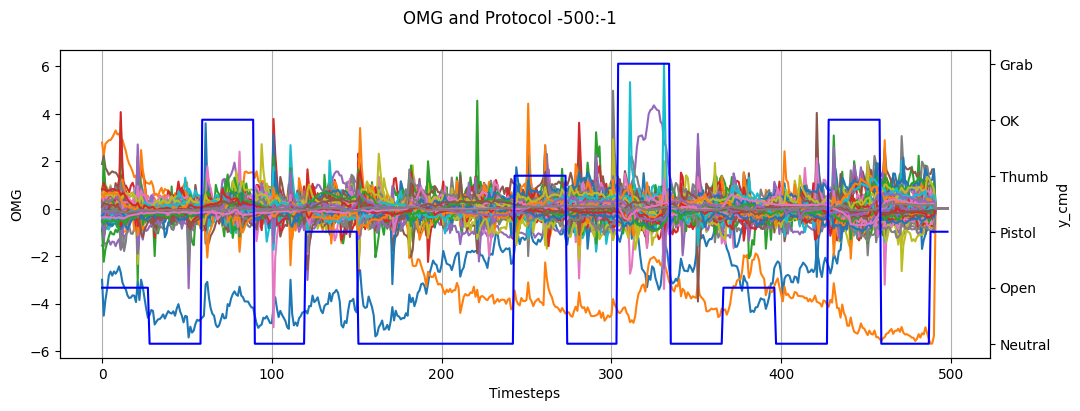

In [129]:
get_graphs(X_train_ewm, y_train, start=-500, end=-1)

# Modeling

---

### SVC

In [130]:
%%time
# Инициализация объекта
model = svm.SVC(
    kernel='rbf',
    random_state=42
)

# Обучение
model.fit(X_train_ewm, y_train)

CPU times: total: 22 s
Wall time: 22.1 s


SVC(random_state=42)

## Prediction

In [131]:
%%time
y_pred_train = model.predict(X_train_ewm)
y_pred_test = model.predict(X_test_ewm)

CPU times: total: 56.7 s
Wall time: 56.8 s


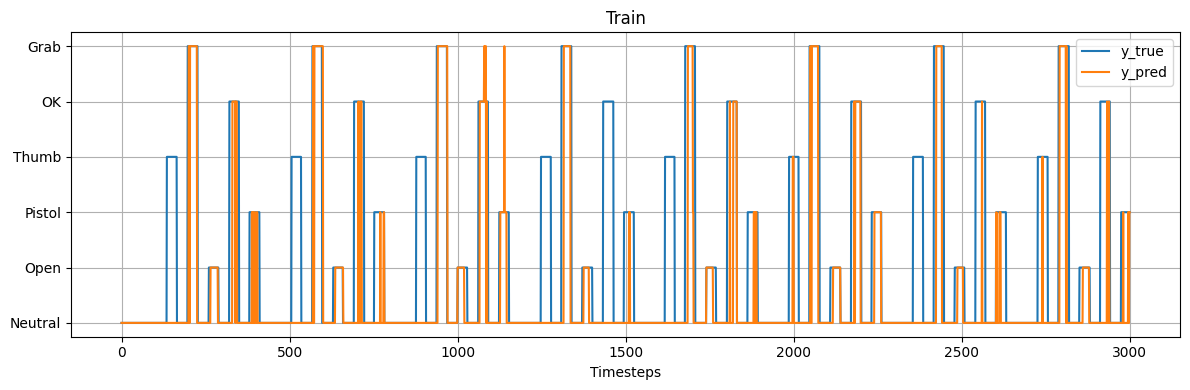

In [132]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_train[:3000],  c='C0', label='y_true')
plt.plot(y_pred_train[:3000], c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

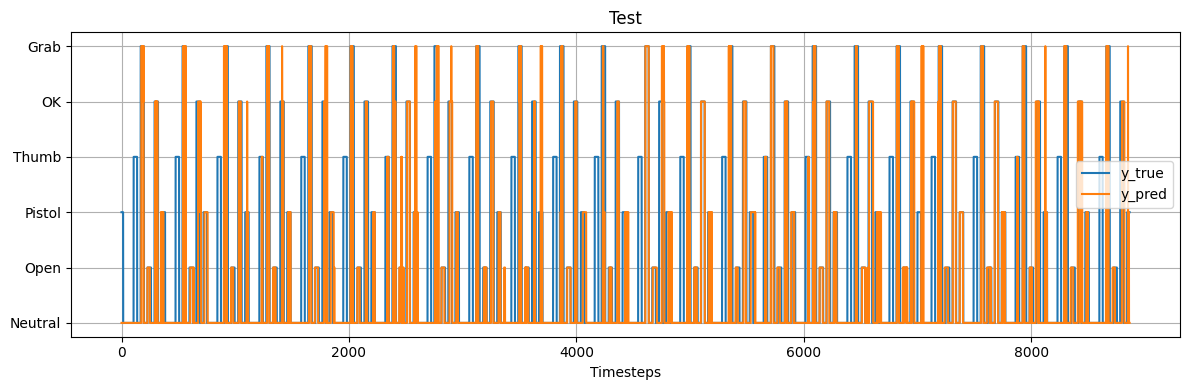

In [133]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_test, c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [134]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train, y_pred_train, target_names=GESTURES, digits=4))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_test, y_pred_test, target_names=GESTURES, digits=4))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, y_pred_test)
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

Train preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.7662    0.9685    0.8556     21117
        Open     0.9495    0.7192    0.8185      2931
      Pistol     0.8480    0.5562    0.6718      2898
       Thumb     0.9653    0.2095    0.3443      2921
          OK     0.8855    0.6086    0.7214      2910
        Grab     0.9529    0.7341    0.8293      2922

    accuracy                         0.8039     35699
   macro avg     0.8946    0.6327    0.7068     35699
weighted avg     0.8292    0.8039    0.7827     35699

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.7180    0.9449    0.8159      5133
        Open     0.8564    0.6923    0.7657       741
      Pistol     0.7180    0.4693    0.5676       765
       Thumb     0.8824    0.0403    0.0771       744
          OK     0.7929    0.5960    0.6805       745
        Grab     0.82

,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,4850,86,101,0,57,39
Open,225,513,0,3,0,0
Pistol,386,0,359,0,2,18
Thumb,714,0,0,30,0,0
OK,285,0,0,0,444,16
Grab,295,0,40,1,57,345


---
---
---
---
---

# Real-time inference

In [42]:
import time
from serial import Serial
from IPython.display import clear_output

In [43]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [135]:
def preprocessing(x, prev, sample_size=10, alpha=0.5):
    if prev is None:
        x = np.delete(x.reshape(1, -1), features_to_remove, axis=1)
        prev = x
        y = x
    else:
        x = np.delete(x.reshape(1, -1), features_to_remove, axis=1)
        prev = np.vstack((prev, x))
        if prev.shape[0] < sample_size:
            prev_scaled = std_scaler.transform(prev)
            prev_pca = pca.transform(prev_scaled)
            y = get_smoothing(pd.DataFrame(prev_pca), sample_size=prev.shape[0], alpha=alpha)[-1]
        else:
            prev = prev[1:]
            prev_scaled = std_scaler.transform(prev)
            prev_pca = pca.transform(prev_scaled)
            y = get_smoothing(pd.DataFrame(prev_pca), sample_size=prev.shape[0], alpha=alpha)[-1]
    return y.reshape(1, -1), prev


def inference(x):
    y = model.predict(x)
    return y


def postprocessing(x, prev, length=5):
    if prev is None:
        prev = np.zeros((length,))
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y.reshape(1,)

## Inference

### Offline (dataset)

In [136]:
df_sim = test_pools[pilot_number-1]
print(df_sim.shape)

(8866, 65)


In [137]:
LENGTH = 5
SAMPLE_SIZE = 10
ALPHA = 0.3

In [138]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous, sample_size=SAMPLE_SIZE, alpha=ALPHA)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [139]:
np.max(ts_diffs)

0.005997896194458008

In [140]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8866, 50)
enc_sample.shape = (8866, 6)
sample_preprocessed.shape = (8866, 1, 48)
y_predicted.shape = (8866, 1)
y_postprocessed.shape = (8866,)
y_commands.shape = (8866, 1)


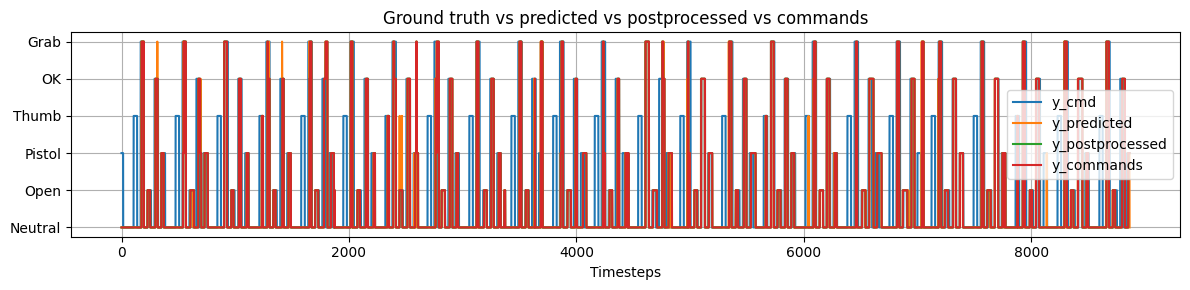

In [141]:
fig = plt.figure(figsize=(12, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [142]:
print(metrics.classification_report(
    y_test, y_dct['y_commands'], target_names=GESTURES, digits=4
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, y_dct['y_commands'].reshape(-1,))
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

              precision    recall  f1-score   support

     Neutral     0.7238    0.9359    0.8163      5133
        Open     0.8774    0.7530    0.8105       741
      Pistol     0.6673    0.4719    0.5528       765
       Thumb     0.9429    0.0444    0.0847       744
          OK     0.7795    0.6027    0.6798       745
        Grab     0.8413    0.5027    0.6293       738

    accuracy                         0.7417      8866
   macro avg     0.8054    0.5518    0.5956      8866
weighted avg     0.7646    0.7417    0.7047      8866



,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,4804,78,138,2,67,44
Open,183,558,0,0,0,0
Pistol,385,0,361,0,0,19
Thumb,711,0,0,33,0,0
OK,289,0,0,0,449,7
Grab,265,0,42,0,60,371


|pilot|f1 weighted|
|-|-|
|`1`|0.7047|
|`2`|0.8783|
|`3`|0.8411|
|`4`|0.9332|

### Online (prosthesis or virtual hand)

In [42]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# ser_port = None
# # ser_port = '/dev/ttyACM0'
# # ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()
    
#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
#     except Exception as e:
#         print(e)
        
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]
    
#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]
    
#     y_previous = y_postprocessed
    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)
    
#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 

---